# Preprocesamiento para Experimentos de Actividad Espontánea
 
Este Cuaderno es muy similar al Preprocesamiento para Evocados, pero sin promediar sobre múltiples estímulos. En lugar de eso se recomienda una inspección visual para obtener un intervalo interesante del Archivo Experimental.

In [1]:
include("SeparaActividadySaturados01.jl")
using SeparaActividadySaturados01
using JLD, PyPlot

La mayoría de los experimentos de actividad espontánea producen archivos de varios GB. Es imposible hacer el prerprocesamiento con 
memoría limitada. Es muy probable que haya que dividir el archivo en cachos.

In [2]:
abrestring="/home/karel/BRWFiles/140116s2cut.brw"
stringgeneral=replace(abrestring, ".brw", "")  

"/home/karel/BRWFiles/140116s2cut"

In [3]:
Datos=AbreyCheca(abrestring)

Dict{String,Any} with 8 entries:
  "minvolt"     => -4125.0
  "maxvolt"     => 4125.0
  "frecuencia"  => 7022.06
  "DatosCrudos" => UInt16[0x0fff 0x0fff … 0x0fff 0x0fff; 0x0805 0x07f7 … 0x07ed…
  "bitdepth"    => 0x0c
  "factor"      => 2.01416
  "numcuadros"  => 2106617
  "duracion"    => 300.0

In [18]:
fmemlibre=Sys.free_memory()/Sys.total_memory()

0.562563707907807

In [ ]:
# Si los datos andan en un arreglo de lista en lugar de cuadrado, los ponemos cuadrados
if size(Datos["DatosCrudos"])[1] != 4096
DatosCrudosArreglados=reshape(Datos["DatosCrudos"], (4096, Datos["numcuadros"]))
else
DatosCrudosArreglados=Datos["DatosCrudos"]
end;

In [17]:
# si la fraccion de memoria libre es inferior a 0.2, tenemos que cortar un cacho de los datos. Que tan chico el cacho depende... 
# toca probar
#if fmemlibre <0.6
cacho=round(Int, Datos["numcuadros"]/60)
DatosCrudosArreglados=DatosCrudosArreglados[:,1:cacho]
#    end;
# Liberar memoria
Datos["DatosCrudos"]=0

0

In [20]:
size(DatosCrudosArreglados)

(4096, 35110)

In [13]:
### parametetros globales.
freq=Datos["frecuencia"]/1000 #cuadros por milisegundo.
factor=Datos["factor"] #Factor de conversion de numeros enteros a microVolts
retrazo=round(Int, ceil(5*freq))
final=round(Int, ceil(60*freq))
latencia=round(Int, ceil(1.5*freq))


11

In [21]:
 DatosCentrados=FormaMatrizDatosCentrados(DatosCrudosArreglados, factor);
# libera memoria
DatosCrudosArreglados=0


0

In [22]:
size(DatosCentrados)

(64, 64, 35110)

In [26]:
cuadrosmax=size(DatosCentrados)[3]
tiempototalms=round(cuadrosmax/freq, 1) 
println("Tienes ", cuadrosmax, " cuadros de muestreo a ", round(freq,4), " cuadros por milisegundo")
    println( "Esto corresponde a  ", tiempototalms, "ms." )

Tienes 35110 cuadros de muestreo a 7.0221 cuadros por milisegundo
Esto corresponde a  5000.0ms.


In [28]:
#los parametros son datos promediados, frecuencia, tiempo post estimulo en ms, umbral en microvolts, umbral de saturación en microvolts
PruebaRespuesta=BuscaCanalRespActPot(DatosCentrados,freq, 120,-120,-800)
# y luego los saturados
iniciobusqueda=retrazo
finbusqueda=retrazo+4*latencia
Saturados=BuscaSaturados(DatosCentrados,1200,iniciobusqueda,finbusqueda)
numerosaturados=length(Saturados)
println("Encontramos ", numerosaturados, " canales probablemente saturados.")
println("Encontramos ", length(PruebaRespuesta), " canales probablemente con actividad.")


Encontramos 5 canales probablemente saturados.
Encontramos 1263 canales probablemente con actividad.


In [29]:
using PyPlot

INFO: Recompiling stale cache file /home/karel/.julia/lib/v0.6/PyPlot.ji for module PyPlot.


### inspección visual. 
Podemos tomar una imagen de la desviación estándar por canal y sobreponerle unas marcas para los canales "respuesta".
De ahí podemos tomar un ejemplo para dibujar el trazo en ese canal.

In [30]:
DesviacionPorCanal=zeros(64,64)
for j=1:64
    for k=1:64
        ChorizoExemplo=reshape(DatosCentrados[j,k,:],cuadrosmax)
        DesviacionPorCanal[j,k]=std(ChorizoExemplo)
    end
end

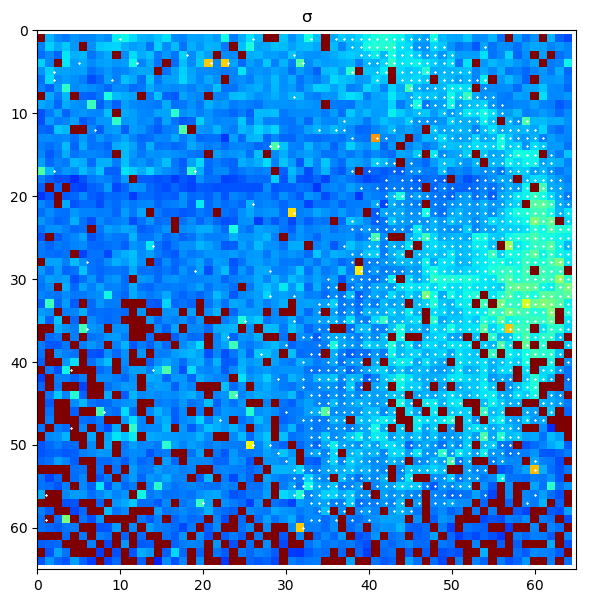

PyObject <matplotlib.collections.PathCollection object at 0x7feb603db898>

In [48]:
figure(figsize=(7,7))
xlim(0,65)
ylim(65,0)
title("σ")
limites=50
imagen=imshow(DesviacionPorCanal, origin="lower", interpolation="nearest",cmap="jet", 
                      vmin=10,vmax=limites, extent=[0,64.5,0.5,64.5])

x=[]
y=[]
for j in PruebaRespuesta
  append!(x,j[2])
   append!(y,j[1])
end

scatter(x,y, marker="x",c="white", s=0.5)

Escogamos uno de los que parecen estar en la "sombra luminosa" del Cuerno de Amon y que estén marcados con x blanca.

In [50]:
egtrazo=DatosCentrados[33,56,:];

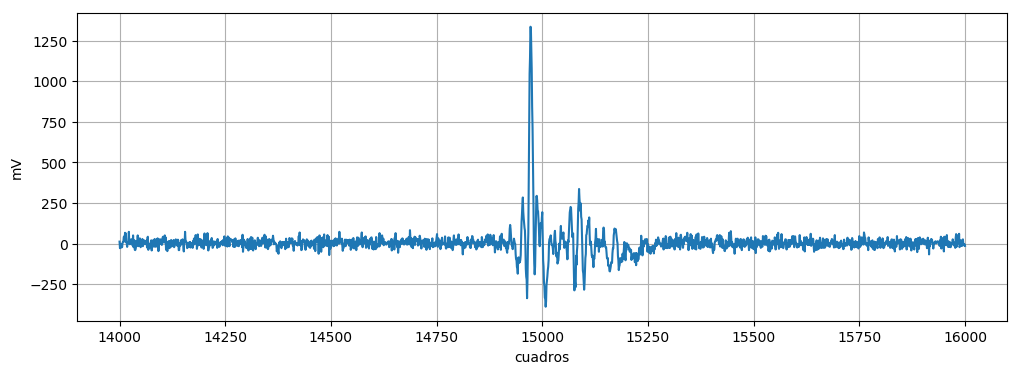

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7feb601e3278>

In [63]:
figure(figsize=(12,4))
xlabel("cuadros")
ylabel("mV")
#subintervalo a graficar, por omision, todo primero, es decir desde=1, hasta=cuadrosmax
desde=14000
hasta=16000
intervalo=desde:hasta
grid()
plot(intervalo,egtrazo[intervalo])

Tomaremos el intervalo interesante y guardaremos esos datos en un archivo con toda la información de saturados y respuestas, 
de la misma forma que como se hace con los evocados. A diferencia de éstos, no tenemos parámetros de latencia, en lugar de eso
tendremos una indicacion de "de donde a donde se cortaron los datos", en cuadros.

In [64]:
dirname(stringgeneral), basename(stringgeneral)

("/home/karel/BRWFiles", "140116s2cut")

In [65]:
dirgen=dirname(stringgeneral)
basegen=basename(stringgeneral)
#una palabra para indicar el intervalo 
palabritaespecial="Corte_01_"
outname=string(dirgen,palabritaespecial, basegen, ".jld")
#aqui hay que arreglar el rollo del directorio

save(outname,
     "LFPSaturados", DatosCentrados[:,:,desde:hasta],
     "desde", desde,
    "hasta", hasta,
     "freq",freq,
     "Canalesrespuesta", PruebaRespuesta,
     "CanalesSaturados", Saturados)

In [66]:
outname

"dirnameCorte_01_140116s2cut.jld"